In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from decimal import Decimal
import os
from src.loader import SnapshotsLoader

In [2]:
MAX_DEPTH = 20
DATA_FOLDER = 'data/'
SNAPSHOTS = 'snapshots_{instrument}_{date}.csv'
TRADES = 'trades_{instrument}_{date}.csv'

BTC_USDT = 'btc-usdt'
DATE = '20211015'

snapshots = SnapshotsLoader.get_snapshots(os.path.join(DATA_FOLDER, SNAPSHOTS.format(instrument=BTC_USDT, date=DATE)))

Successfully loaded 864253 snapshots!


In [3]:
assert np.all(snapshots.depth == MAX_DEPTH)

# Calculate the midprice & orderbook imbalance

,timestamp,update_id,market,depth,ask_prices,ask_amounts,bid_prices,bid_amounts,date,best_ask,best_bid,mid,total_bid_amount,total_ask_amount,imbalance
0,1634169600034644741,14311550913,btc-usdt,20,"[57367.01, 57370.82, 57370.84, 57370.85, 57372...","[0.00909, 0.04631, 0.00146, 0.13074, 0.06798, ...","[57367, 57366.99, 57366.98, 57362.24, 57361.24...","[1.18061, 1.93, 0.64, 0.22, 0.2, 0.00591, 0.22...",2021-10-14 00:00:00.034645,57367.01,57367,57367.005,6.51589,3.81535,0.2613955343211463483570220032
1,1634169600127002542,14311550939,btc-usdt,20,"[57367.01, 57370.84, 57370.85, 57372.38, 57373...","[0.00001, 0.00146, 0.13074, 0.06798, 0.07774, ...","[57367, 57366.99, 57366.98, 57362.24, 57361.24...","[1.17774, 1.93, 0.64, 0.22, 0.2, 0.00591, 0.22...",2021-10-14 00:00:00.127002,57367.01,57367,57367.005,6.62687,3.39309,0.3227338232887157234160615412
2,1634169600226964010,14311550983,btc-usdt,20,"[57370.84, 57370.85, 57373.92, 57374.28, 57374...","[0.08756, 0.13074, 0.07774, 0.06798, 0.14857, ...","[57370.83, 57367.01, 57366.98, 57362.24, 57361...","[2.21189, 0.1383, 0.64, 0.22, 0.2, 0.00591, 0....",2021-10-14 00:00:00.226964,57370.84,57370.83,57370.835,5.86723,3.63086,0.2354547072095547631155316490
3,1634169600326794942,14311550994,btc-usdt,20,"[57370.84, 57370.85, 57373.92, 57374.28, 57374...","[0.55557, 0.13074, 0.07774, 0.06798, 0.14857, ...","[57370.83, 57367.01, 57366.98, 57362.24, 57361...","[2.24189, 0.1383, 0.64, 0.22, 0.2, 0.00591, 0....",2021-10-14 00:00:00.326795,57370.84,57370.83,57370.835,6.20399,4.30470,0.1807351820255426699236536619
4,1634169600426930803,14311551001,btc-usdt,20,"[57370.84, 57370.85, 57373.91, 57373.92, 57374...","[0.55315, 0.13074, 0.14883, 0.07774, 0.06798, ...","[57370.83, 57367.01, 57366.98, 57362.24, 57361...","[2.24154, 0.1383, 0.64, 0.22, 0.2, 0.00591, 0....",2021-10-14 00:00:00.426931,57370.84,57370.83,57370.835,6.05621,4.37328,0.1613626361404057149486695898


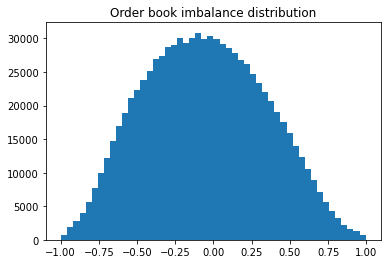

In [4]:
snapshots['mid'] = (snapshots.best_ask + snapshots.best_bid) / 2
snapshots['total_bid_amount'] = snapshots.bid_amounts.apply(sum)
snapshots['total_ask_amount'] = snapshots.ask_amounts.apply(sum)
snapshots['imbalance'] = (snapshots.total_bid_amount - snapshots.total_ask_amount) / (snapshots.total_bid_amount + snapshots.total_ask_amount)

plt.hist(snapshots.imbalance, bins=50)
plt.title('Order book imbalance distribution')
snapshots.head()

In [5]:
snapshots.imbalance.mean(), snapshots.imbalance.median()

(-0.05491183647331868, -0.06405462670030147)

There were more sellers during that day.

# Aggregate the data to 1 minute orderbook summaries

In [6]:
snapshots_minutes = snapshots.groupby(by=snapshots.date.dt.floor('T'))[['mid', 'imbalance']].mean()

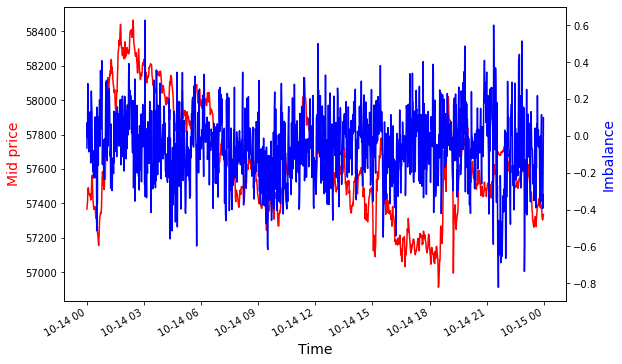

In [7]:
def plot_mid_and_imbalance(df):
    fig, ax = plt.subplots(figsize=(9, 6))
    minutes = mdates.MinuteLocator(interval=5)
    minutes_ = mdates.DateFormatter('%I:%M %p')
    ax.xaxis.set_major_locator(minutes)
    ax.xaxis.set_major_formatter(minutes_)
    
    ax.plot(df.index, df.mid, color="red")
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Mid price", color="red", fontsize=14)

    ax2 = ax.twinx()
    ax2.plot(df.index, df.imbalance, color="blue")
    ax2.set_ylabel("Imbalance", color="blue", fontsize=14)
    fig.autofmt_xdate()

plot_mid_and_imbalance(snapshots_minutes)

# Calculate the mean of the mid price & orderbook imbalance with a rolling window of  1 hour

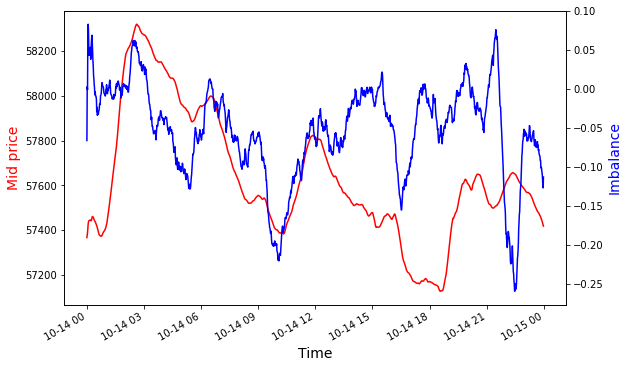

In [8]:
snapshots_ma60 = snapshots_minutes.rolling(60, min_periods=1).mean()
plot_mid_and_imbalance(snapshots_ma60)

This chart is more readable than 1 minute summaries. It looks like the peaks of both charts usually coincide. When imbalance becomes too high or too low, the trend changes. 

In [9]:
snapshots_ma60.corr()

,mid,imbalance
mid,1.000000,0.187108
imbalance,0.187108,1.000000


# Calculate the immediate average market impact of a market buy and sell order

In [10]:
volumes = np.array([1000, 10000, 50000, 100000, 1000000]) * 1e-5
print(volumes)
print(f'Median ask and bid amounts in the book: {snapshots.total_ask_amount.median()}, {snapshots.total_bid_amount.median()}')

[ 0.01  0.1   0.5   1.   10.  ]
Median ask and bid amounts in the book: 3.86254, 3.38544


The exact analysis of orders of size 10 is problematic, we can only draw some estimations. We can conclude that the slippage of the execution of such an order is very big.

There's also a problem that sometimes there are not enough orders in the book to do the calculations. I see 3 possible workarounds:
1. Drop all rows with thin order books.
2. If there are not enough orders, assume that the price changed to the 20th level of the book.
3. Interpolate the price change given the volume that can be traded using the first 20 levels.

Below, I find the level of the order book such that the cumulative volume of all levels below is sufficient to fill the order. 

In [11]:
def find_impacts(df, volumes, strategy='nothing'):
    volumes = np.array(list(map(Decimal, volumes)))
    def look_for(mid, prices, amounts):
        prices = np.array(prices)
        indices = np.searchsorted(np.cumsum(amounts), volumes)
        good_indices = indices < MAX_DEPTH
        if strategy == 'clip':
            indices[~good_indices] = MAX_DEPTH - 1
            moved_prices = prices[indices]
        elif strategy == 'approximate':
            indices[~good_indices] = MAX_DEPTH - 1
            moved_prices = prices[indices]
            book_amount = sum(amounts)
            moved_prices[~good_indices] += (prices[MAX_DEPTH - 1] - mid) / book_amount* (volumes[~good_indices] - book_amount)
        elif strategy == 'nothing':
            if not good_indices.all():
                raise ValueError("Please specify strategy for orders that are require more than 20 levels from the book.")            
            moved_prices = prices[indices]
        return moved_prices

    buy_worst_price = df.apply(lambda row: look_for(row.mid, row.ask_prices, row.ask_amounts), axis=1)
    buy_impacts = (buy_worst_price / df.mid) - 1
    
    sell_worst_price = df.apply(lambda row: look_for(row.mid, row.bid_prices, row.bid_amounts), axis=1)
    sell_impacts = (sell_worst_price / df.mid) - 1
    return buy_impacts.mean() * 100, sell_impacts.mean() * 100

In [12]:
buy_impacts_dropped, sell_impacts_dropped = find_impacts(snapshots[np.logical_and(snapshots.total_ask_amount > 1, snapshots.total_bid_amount > 1)], volumes[:-1])
buy_impacts_clipped, sell_impacts_clipped = find_impacts(snapshots, volumes, strategy='clip')
buy_impacts_approx, sell_impacts_approx = find_impacts(snapshots, volumes, strategy='approximate')

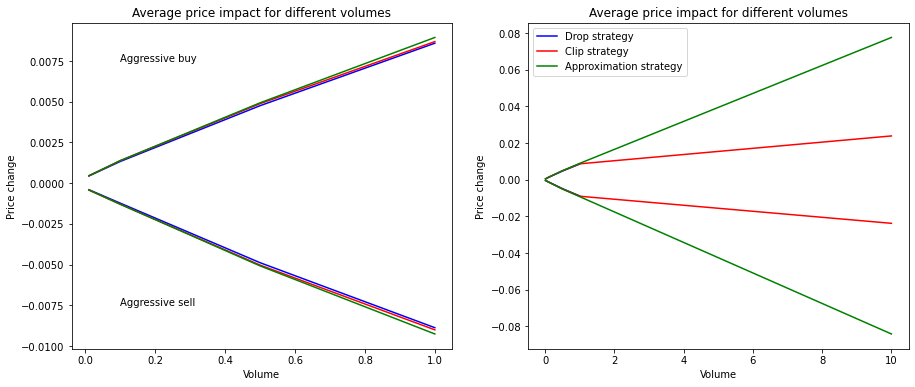

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, ax in enumerate(axes): 
    ax.set_title('Average price impact for different volumes')
    ax.plot(volumes[:-1], buy_impacts_dropped, c='blue', label='Drop strategy')
    ax.plot(volumes[:-1], sell_impacts_dropped, c='blue')
    
    if i == 0:
        ax.plot(volumes[:-1], buy_impacts_clipped[:-1], c='red', label='Clip strategy')
        ax.plot(volumes[:-1], sell_impacts_clipped[:-1], c='red')
        ax.plot(volumes[:-1], buy_impacts_approx[:-1], c='green', label='Approximation strategy')
        ax.plot(volumes[:-1], sell_impacts_approx[:-1], c='green')
        
        ax.text(0.1, 0.0075, "Aggressive buy")
        ax.text(0.1, -0.0075, "Aggressive sell")
    else:
        ax.plot(volumes, buy_impacts_clipped, c='red', label='Clip strategy')
        ax.plot(volumes, sell_impacts_clipped, c='red')
        ax.plot(volumes, buy_impacts_approx, c='green', label='Approximation strategy')
        ax.plot(volumes, sell_impacts_approx, c='green')
    ax.set_xlabel('Volume')
    ax.set_ylabel('Price change')

plt.legend();

There is a clear linear dependency between the volume and the market impact. For volumes smaller than 1 all strategies for processing thin order books give very similar results. 

However, for orders of size 10 drop strategy is not applicable because we need to drop more than half of points. Two other strategies also give very different results, we can't rely on them.

In [15]:
trades = pd.read_csv(os.path.join(DATA_FOLDER, TRADES.format(instrument=BTC_USDT, date=DATE)))
trades = trades.groupby(by='timestamp')['amount'].sum()

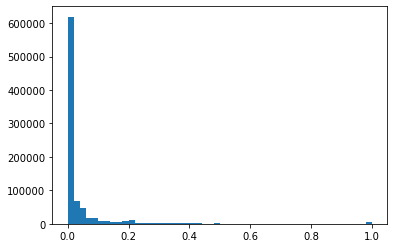

In [16]:
plt.hist(np.clip(trades, 0, 1), bins=50);

In [17]:
print(f'Number of trades with amount > 1: {(trades > 1).sum()}')

Number of trades with amount > 1: 5030
